In [1]:
from langchain_community.document_loaders import (
    UnstructuredHTMLLoader,
    BSHTMLLoader,
    TextLoader,
    JSONLoader,
)
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import (
    CharacterTextSplitter,
    RecursiveCharacterTextSplitter,
    MarkdownTextSplitter,
)
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.vectorstores import Chroma
from langchain.chains import (
    RetrievalQA,
    ConversationalRetrievalChain,
    RetrievalQAWithSourcesChain,
)
from langchain.memory import ConversationBufferMemory
from langchain_community.llms import LlamaCpp
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from bert_score import plot_example, score

import logging
import pickle


logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

## Helpers

In [2]:
retriever = "mmr"
model = "llama-2-7b.Q3_K_M"

persist_directory = "./../embeddings"

In [ ]:
def process_llm_response(llm_response):
    print("\n\nSources:")
    for i, source in enumerate(llm_response["source_documents"]):
        m = source.metadata
        print(f"{i + 1}. {m['course_title']} ({m['course_number']}): {m['heading']}")

In [ ]:

class ResponseFormatter:
    def __init__(self):
        self.responses = {
            "question": [],
            "contexts": [],
            "answer": [],
            "ground_truth": [],
        }

    def add_response(self, llm_response, ground_truth):
        self.responses["question"].append(llm_response["query"])
        self.responses["contexts"].append(
            [doc.page_content for doc in llm_response["source_documents"]]
        )
        self.responses["answer"].append(llm_response["result"])
        self.responses["ground_truth"].append(ground_truth)

    def get_responses(self):
        return self.responses
    
    def get_dataframe(self):
        pd.DataFrame(self.responses[["question", "answer", "ground_truth"]])

## Vector Retriever

In [2]:
with open(f"{persist_directory}/embeddings.pickle", 'rb') as handle:
    embeddings = pickle.load(handle)


In [3]:
vectordb = Chroma(
    "documents", # or "transcripts"
    embedding_function=embeddings,
    persist_directory=persist_directory,
    collection_metadata={"hnsw:space": "cosine"},
)

In [4]:
retriever = vectordb.as_retriever(
    search_type=f"{retriever}",
    search_kwargs={"k": 5, "fetch_k": 20},
)

## Quantized Model

In [5]:
llm_open = LlamaCpp(
    model_path=f"./models/{model}.gguf",  # https://huggingface.co/TheBloke/Llama-2-7B-GGUF
    n_ctx=4096,  # 4096 for Llama, 32*1024 for Mistral
    n_gpu_layers=50,
    temperature=0.15,
    top_p=1,
    top_k=40,
    repeat_penalty=1.1,
    max_tokens=1024,
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    stream=True,
)

/Users/patrick/.local/share/virtualenvs/capstone-s4bMLJni/lib/python3.11/site-packages/langchain_core/utils/utils.py:159: UserWarning: WARNING! stream is not default parameter.
                stream was transferred to model_kwargs.
                Please confirm that stream is what you intended.
  warnings.warn(
llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from ./models/llama-2-7b.Q3_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.b

In [7]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm_open,
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True,
    verbose=True,
)

In [10]:
query = "Which class involves time series analysis?"

llm_response = qa_chain(query)
process_llm_response(llm_response)

/Users/patrick/.local/share/virtualenvs/capstone-s4bMLJni/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(




> Entering new RetrievalQA chain...
 The MADS Incomplete Request Form can be found on the MADS website [HERE](https://www.si.umich.edu/current-students/mads-incomplete-request-form).



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =       9.55 ms /    48 runs   (    0.20 ms per token,  5028.28 tokens per second)
llama_print_timings: prompt eval time =   40431.27 ms /   879 tokens (   46.00 ms per token,    21.74 tokens per second)
llama_print_timings:        eval time =   10051.90 ms /    47 runs   (  213.87 ms per token,     4.68 tokens per second)
llama_print_timings:       total time =   51583.09 ms /   926 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the process for requesting an incomplete?
2. n/a (n/a): Course Planning > Q: Where can I find the MADS Academic Calendar and Important Dates?
3. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Use of Slack Apps and Bots
4. n/a (n/a): Additional University Resources > Q: What mental health resources are available to MADS students?
5. n/a (n/a): General Academic Advising > Q: What is the best way to contact the MADS advising team?


## Run the Model

In [12]:
df = pd.read_csv("./evaluation_set.csv")

for _, row in df.iterrows():
    print(row["question"])

Which class involves time series analysis?
Who teaches the SQL and Databases class?
What are the prerequisites for Data Science for Social Good?
When are the office hours for the Math Methods course?
Are there any weekly readings for Milestone II?
What are the outcomes of Qualitative Inquiry?
What textbook is required for SIADS 505?
What textbook is required for Data Manipulation?
Which week of unsupervised learning covers DBSCAN?
How many credits are required to complete the MADS program?
How long do students have to complete the MADS program start to finish?


In [13]:
formatter = ResponseFormatter()

# Or, use the cached one
# with open("./evaluation_set_formatter.pickle", 'rb') as handle:
#     formatter = pickle.load(handle)

In [14]:
for _, row in df.iterrows():
    llm_response = qa_chain(row["question"])
    process_llm_response(llm_response)

    formatter.add_response(llm_response, row["ground_truth"])

    # Save after each response in case this thing crashes
    with open(f"./cache/{retriever}_{model}_formatter.pickle", 'wb') as handle:
        pickle.dump(formatter, handle)

    with open(f"./cache/{retriever}_{model}_responses.pickle", 'wb') as handle:
        pickle.dump(formatter.get_responses(), handle)



> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Data Manipulation and Visual Exploration of Data both involve time series analysis.

Data Manipulation (SIADS 511), Course Schedule: This course begins on Tuesday November 14, 2023, and ends on Monday, December 4, 2023.

Assignments should be submitted by 11:59 pm on the date they are due:

- Assignment 1: Nov 14, 2023
- Assignment 2: Nov 21, 2023
- Assignment 3: Nov 28, 2023
- Assignment 4 & 5: Dec 4, 2023

Visual Exploration of Data (SIADS 521), Course Schedule: This course begins on Tuesday November 14, 2023, and ends on Monday, December 4, 2023.

Assignments should be submitted by 11:59 pm on the date they are due:

- Assignment 1: Nov 14, 2023
- Assignment 2: Nov 21, 2023
- Assignment 3: Nov 28, 2023
- Assignment 4 & 5: Dec 4, 2023

Communicating Data Science Results (SIADS 523), Course Schedule: This course begins on Tuesday November 14, 2023, and ends on Monday, December 4, 2023.

Assignments should be submitted by 11:59 pm on the date they are due:

- Assignment 1: Nov 14, 202


llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =     136.91 ms /   759 runs   (    0.18 ms per token,  5543.91 tokens per second)
llama_print_timings: prompt eval time =   28869.81 ms /   790 tokens (   36.54 ms per token,    27.36 tokens per second)
llama_print_timings:        eval time =   90460.31 ms /   758 runs   (  119.34 ms per token,     8.38 tokens per second)
llama_print_timings:       total time =  128162.88 ms /  1548 tokens



> Finished chain.


Sources:
1. Data Mining II (SIADS 632): Learning Outcomes
2. n/a (n/a): General Academic Advising > Q: Can you advise me on which courses are the heaviest workload, the most difficult, etc?
3. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
4. Visual Exploration of Data (SIADS 521): Syllabus Course Overview And Prerequisites
5. Communicating Data Science Results (SIADS 523): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The instructor is Graham Hukill (gshukill@umich.edu). The course assistants are Derek Bruckner (dbrucknr@umich.edu), Emily Schemanske (landise@umich.edu), Jungseo Lee (jungseo@umich.edu), Toby Kemp (tobyk@umich.edu).



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      30.08 ms /    85 runs   (    0.35 ms per token,  2826.08 tokens per second)
llama_print_timings: prompt eval time =   19832.26 ms /   558 tokens (   35.54 ms per token,    28.14 tokens per second)
llama_print_timings:        eval time =   14975.03 ms /    84 runs   (  178.27 ms per token,     5.61 tokens per second)
llama_print_timings:       total time =   36789.82 ms /   642 tokens



> Finished chain.


Sources:
1. SQL and Databases (SIADS 511): Instructor And Course Assistants
2. SQL and Databases (SIADS 511): Course Outcomes
3. SQL and Databases (SIADS 511): Technology Requirements (Unique To This Course)
4. SQL and Databases (SIADS 511): Textbooks
5. SQL and Databases (SIADS 511): Course Schedule


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The prerequisites for SIADS 688 include: Preceded or accompanied by SIADS 630, 631, and 694; (C- or better) This course was initially developed by Dr. Yan Chen.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      12.73 ms /    59 runs   (    0.22 ms per token,  4633.63 tokens per second)
llama_print_timings: prompt eval time =   30874.30 ms /   870 tokens (   35.49 ms per token,    28.18 tokens per second)
llama_print_timings:        eval time =   10677.79 ms /    58 runs   (  184.10 ms per token,     5.43 tokens per second)
llama_print_timings:       total time =   42693.86 ms /   928 tokens



> Finished chain.


Sources:
1. Data Science for Social Good (SIADS 688): Course Syllabus for SIADS 688: Data Science for Social Good Course Overview and Prerequisites
2. Communicating Data Science Results (SIADS 523): Course Syllabus SIADS 523: Communicating Data Science Results (Fall 2023) Course Overview And Prerequisites
3. n/a (n/a): Academics > Master of Applied Data Science (MADS) > Summary of Degree Requirements
4. Data Science Ethics (SIADS 503): Course Learning Outcomes
5. Data Science for Social Good (SIADS 688): Assignments And Grading You Are Expected To Read An Assigned Paper On Perusall Before Watching Each Lecture, And Complete A Problem Set Afterwards.


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The office hours for Math Methods are on Wednesdays from 4-5 PM EST and Fridays from 9-10 AM EST. The office hours for Unsupervised Learning are on Tuesdays from 5-6 PM EST and Fridays from 12-1 PM EST. The office hours for Experiment Design and Analysis are on Tuesdays from 5-6 PM EST and Saturdays from 5-6 PM EST. The office hours for Causal Inference are on Fridays from 3-4 PM EST and Sundays from 3-4 PM EST. The office hours for Machine Learning Pipelines are on Thursdays from 8-9 PM EST and Wednesdays from 2-3 PM EST.


llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      35.61 ms /   171 runs   (    0.21 ms per token,  4802.02 tokens per second)
llama_print_timings: prompt eval time =   27557.85 ms /   878 tokens (   31.39 ms per token,    31.86 tokens per second)
llama_print_timings:        eval time =   17991.12 ms /   170 runs   (  105.83 ms per token,     9.45 tokens per second)
llama_print_timings:       total time =   47839.06 ms /  1048 tokens



> Finished chain.


Sources:
1. Math Methods II (SIADS 602): Course Schedule
2. Unsupervised Learning (SIADS 543): Office Hours Schedule:
3. Experiment Design and Analysis (SIADS 631): Course Schedule
4. Causal Inference (SIADS 630): Office Hours:
5. Machine Learning Pipelines (SIADS 643): Weekly Office Hours Via Zoom (Ann Arbor, Michigan Time):


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 No, there are no weekly readings for Milestone II.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =       4.33 ms /    16 runs   (    0.27 ms per token,  3691.74 tokens per second)
llama_print_timings: prompt eval time =   25999.43 ms /   741 tokens (   35.09 ms per token,    28.50 tokens per second)
llama_print_timings:        eval time =    4885.41 ms /    15 runs   (  325.69 ms per token,     3.07 tokens per second)
llama_print_timings:       total time =   31449.39 ms /   756 tokens



> Finished chain.


Sources:
1. Milestone II (SIADS 696): Weekly Readings
2. Milestone II (SIADS 696): Project Component
3. Milestone I (SIADS 593): 6.0 Office Hours
4. Milestone II (SIADS 696): Re-Grade Policy
5. Milestone I (SIADS 593): 7.0 Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Qualitative data analysis is a process of making sense out of data. It is not a single method or a single technique. It is a process that involves a number of steps and a number of methods and techniques. Qualitative data analysis is a process of making sense out of data. It is not a single method or a single technique. It is a process that involves a number of steps and a number of methods and techniques. Qualitative data analysis is a process of making sense out of data. It is not a single method or a single technique. It is a process that involves a number of steps and a number of methods and techniques. Qualitative data analysis is a process of making sense out of data. It is not a single method or a single technique. It is a process that involves a number of steps and a number of methods and techniques. Qualitative data analysis is a process of making sense out of data. It is not a single method or a single technique. It is a process that involves a number of steps and a number o


llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =     490.05 ms /  1024 runs   (    0.48 ms per token,  2089.57 tokens per second)
llama_print_timings: prompt eval time =   37565.32 ms /  1208 tokens (   31.10 ms per token,    32.16 tokens per second)
llama_print_timings:        eval time =  209134.46 ms /  1024 runs   (  204.23 ms per token,     4.90 tokens per second)
llama_print_timings:       total time =  325363.51 ms /  2232 tokens



> Finished chain.


Sources:
1. Qualitative Inquiry for Data Scientists (SIADS 601): Learning Outcomes
2. Qualitative Inquiry for Data Scientists (SIADS 601): Course Handouts
3. Qualitative Inquiry for Data Scientists (SIADS 601): Grading And Assignments Overview
4. Experiment Design and Analysis (SIADS 631): Learning Outcomes
5. Causal Inference (SIADS 630): Accommodations


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 SIADS 505 does not require a textbook.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      12.79 ms /    16 runs   (    0.80 ms per token,  1250.98 tokens per second)
llama_print_timings: prompt eval time =   16444.84 ms /   352 tokens (   46.72 ms per token,    21.40 tokens per second)
llama_print_timings:        eval time =    4911.69 ms /    16 runs   (  306.98 ms per token,     3.26 tokens per second)
llama_print_timings:       total time =   24351.95 ms /   368 tokens



> Finished chain.


Sources:
1. Health Analytics (SIADS 681): Weekly Readings or Textbook Information
2. Applied Natural Language Processing (SIADS 655): Textbook Information
3. Presenting Uncertainty (SIADS 524): Required Textbook
4. Math Methods I (SIADS 502): Academic Integrity
5. Database Architecture & Technology (SIADS 611): Assignments And Percentage Of Final Grade


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 None.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =       2.62 ms /     4 runs   (    0.65 ms per token,  1527.30 tokens per second)
llama_print_timings: prompt eval time =   24392.66 ms /   647 tokens (   37.70 ms per token,    26.52 tokens per second)
llama_print_timings:        eval time =     278.26 ms /     3 runs   (   92.75 ms per token,    10.78 tokens per second)
llama_print_timings:       total time =   26275.44 ms /   650 tokens



> Finished chain.


Sources:
1. Data Manipulation (SIADS 505): Course Syllabus Course Overview And Prerequisites
2. Communicating Data Science Results (SIADS 523): Required Textbook
3. Data Manipulation (SIADS 505): Library Access
4. Math Methods II (SIADS 602): Textbooks For Optional Readings
5. Health Analytics (SIADS 681): Weekly Readings or Textbook Information


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 The DBSCAN algorithm is covered in week 2 of unsupervised learning.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      11.97 ms /    19 runs   (    0.63 ms per token,  1586.90 tokens per second)
llama_print_timings: prompt eval time =   20925.43 ms /   470 tokens (   44.52 ms per token,    22.46 tokens per second)
llama_print_timings:        eval time =    1545.79 ms /    18 runs   (   85.88 ms per token,    11.64 tokens per second)
llama_print_timings:       total time =   24568.60 ms /   488 tokens



> Finished chain.


Sources:
1. Unsupervised Learning (SIADS 543): Learning Outcomes: Week 2
2. SQL and Databases (SIADS 511): Course Schedule
3. Unsupervised Learning (SIADS 543): Schedule
4. Learning Analytics and Educational Data Science (SIADS 680): Office Hours Via Zoom (Ann Arbor, Michigan Time - Eastern Time Zone)
5. Unsupervised Learning (SIADS 543): Quizzes


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 34 credits are required to complete the program.



llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      10.95 ms /    14 runs   (    0.78 ms per token,  1278.54 tokens per second)
llama_print_timings: prompt eval time =   43085.20 ms /  1012 tokens (   42.57 ms per token,    23.49 tokens per second)
llama_print_timings:        eval time =    1655.18 ms /    13 runs   (  127.32 ms per token,     7.85 tokens per second)
llama_print_timings:       total time =   50436.78 ms /  1025 tokens



> Finished chain.


Sources:
1. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
2. n/a (n/a): Course Planning > Q: What is the recommended number of credits students should take?
3. n/a (n/a): Course Planning > Q: When will courses be offered next?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. Unsupervised Learning (SIADS 543): Grading And Course Checklist


> Entering new RetrievalQA chain...


Llama.generate: prefix-match hit


 Per the [MADS Student Handbook](https://docs.google.com/document/d/1YEOcpdONdme5kmpNEnZpdbJeVFhEIw1pS0wq16QdH1I/edit?usp=sharing), "students are expected to complete all coursework within five years from the date of first enrollment in the program. Students exceeding this time limit must file a petition for modification or waiver of policy. Petitions must describe explicitly the amount of work remaining and a timeline for completion. Students must be making good progress and have good academic standing to receive an extension. A student who does not complete degree requirements within five years and does not petition for an extension may be withdrawn from the program and required to apply for readmission".


llama_print_timings:        load time =    9199.15 ms
llama_print_timings:      sample time =      85.27 ms /   182 runs   (    0.47 ms per token,  2134.32 tokens per second)
llama_print_timings: prompt eval time =   43382.21 ms /   957 tokens (   45.33 ms per token,    22.06 tokens per second)
llama_print_timings:        eval time =   37966.21 ms /   181 runs   (  209.76 ms per token,     4.77 tokens per second)
llama_print_timings:       total time =   89992.42 ms /  1138 tokens



> Finished chain.


Sources:
1. n/a (n/a): General Academic Advising > Q: How long do I have to complete the program?
2. n/a (n/a): Course Planning > Q: How are the MADS courses/semesters set up?
3. n/a (n/a): Grades/Transcripts > Q: What is the minimum GPA requirement for MADS students?
4. Milestone II (SIADS 696): Letter Grades, Course Grades
5. n/a (n/a): MADS Slack Policy, Standards, and Practices > MADS Slack Standards and Processes > Leaving Course Channels


## Evaluation with BERTScore

In [22]:
with open(f"./cache/{retriever}_{model}_responses.pickle", "rb") as handle:
    rag_responses = pickle.load(handle)

In [39]:
for i in range(len(rag_responses["question"])):
    print(rag_responses["question"][i])
    print(">>>", rag_responses["ground_truth"][i])
    print("-" * 100)
    print(rag_responses["answer"][i])
    print("")
    print("=" * 100)
    print("=" * 100)
    print("")

Which class involves time series analysis?
>>> Data Mining II, SIADS 632 includes a particular focus on time series analysis.
----------------------------------------------------------------------------------------------------
 Data Manipulation and Visual Exploration of Data both involve time series analysis.

Data Manipulation (SIADS 511), Course Schedule: This course begins on Tuesday November 14, 2023, and ends on Monday, December 4, 2023.

Assignments should be submitted by 11:59 pm on the date they are due:

- Assignment 1: Nov 14, 2023
- Assignment 2: Nov 21, 2023
- Assignment 3: Nov 28, 2023
- Assignment 4 & 5: Dec 4, 2023

Visual Exploration of Data (SIADS 521), Course Schedule: This course begins on Tuesday November 14, 2023, and ends on Monday, December 4, 2023.

Assignments should be submitted by 11:59 pm on the date they are due:

- Assignment 1: Nov 14, 2023
- Assignment 2: Nov 21, 2023
- Assignment 3: Nov 28, 2023
- Assignment 4 & 5: Dec 4, 2023

Communicating Data Scien

In [50]:
responses_df = pd.DataFrame(rag_responses)

responses_df["eye_check"] = [
    -1,  # "Which class involves time series analysis?",
    1,  # "Who teaches the SQL and Databases class?",
    1,  # "What are the prerequisites for Data Science for Social Good?",
    -1,  # "When are the office hours for the Math Methods course?",
    1,  # "Are there any weekly readings for Milestone II?",
    -1,  # "What are the outcomes of Qualitative Inquiry?",
    -1,  # "What textbook is required for SIADS 505?",
    -1,  # "What textbook is required for Data Manipulation?",
    1,  # "Which week of unsupervised learning covers DBSCAN?",
    1,  # "How many credits are required to complete the MADS program?",
    1,  # "How long do students have to complete the MADS program start to finish?",
]

In [54]:
scores = [
    [
        t.item()
        for t in score(
            [rag_responses["answer"][i]],
            [rag_responses["ground_truth"][i]],
            rescale_with_baseline=True,
            lang="en",
        )
    ]
    for i in range(len(rag_responses["question"]))
]

with open(f"./cache/{retriever}_{model}_bertscores.pickle", "wb") as handle:
    pickle.dump(scores, handle)

In [69]:
with open(f"./cache/{retriever}_{model}_bertscores.pickle", "rb") as handle:
    scores = pickle.load(handle)

bert_df = pd.concat(
    [
        responses_df,
        pd.DataFrame(scores, columns=["precision", "recall", "f1"]),
    ],
    axis="columns",
)

bert_df["abs_diff"] = (bert_df["eye_check"] - bert_df["f1"]).abs()

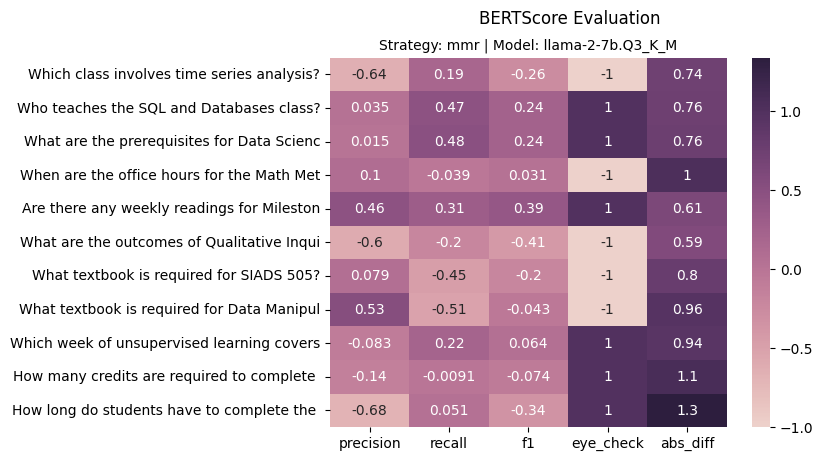

In [70]:
sns.heatmap(
    bert_df[["precision", "recall", "f1", "eye_check", "abs_diff"]],
    yticklabels=bert_df["question"].str[:42],
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)

plt.suptitle("BERTScore Evaluation")
plt.title(f"Strategy: {retriever} | Model: {model}", fontsize=10)

plt.show()